Team:

* Csatári Dominik - FV1TW4
* Fodor Péter - M63ES5
* Tabajdi Csanád - JLRZJS


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import itertools
import torch.optim as optim
import copy

In [6]:
#load local data
!gdown https://drive.google.com/uc?id=1YaBXAIX1zxsJHyUy4N9ov-BPJP2z2jrD
!gdown https://drive.google.com/uc?id=1iDZRN0YXMf79H1EIlpkDqOWeL-lRWxmB

#training
!gdown https://drive.google.com/uc?id=13IfSR4hgYm24bkbdMpbgZ_u99ViLIUu-
!gdown https://drive.google.com/uc?id=1Lw6IF-fGMPm6Zs2tEhEHERovrMpHVPle

Downloading...
From: https://drive.google.com/uc?id=1YaBXAIX1zxsJHyUy4N9ov-BPJP2z2jrD
To: /content/unet_1000_8.pt
100% 124M/124M [00:00<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iDZRN0YXMf79H1EIlpkDqOWeL-lRWxmB
To: /content/sample.png
100% 850k/850k [00:00<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=13IfSR4hgYm24bkbdMpbgZ_u99ViLIUu-
To: /content/train_set_normalized_masks.npy
100% 1.65G/1.65G [00:24<00:00, 67.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lw6IF-fGMPm6Zs2tEhEHERovrMpHVPle
To: /content/test_set_normalized_masks.npy
100% 14.0M/14.0M [00:00<00:00, 31.5MB/s]


In [ ]:
class DoubleConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down2(nn.Module):
    def __init__(self, in_channels, out_channels, down_with_conv2d=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv2(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up2(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv2(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# Channel numbers
ChN = [64, 128, 256, 512, 1024]

In [ ]:
# Creating U-Net
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv2(n_channels, ChN[0])
        self.down1 = Down2(ChN[0], ChN[1])
        self.down2 = Down2(ChN[1], ChN[2])
        self.down3 = Down2(ChN[2], ChN[3])
        self.down4 = Down2(ChN[3], ChN[4])
        self.up1 = Up2(ChN[4], ChN[3], bilinear)
        self.up2 = Up2(ChN[3], ChN[2], bilinear)
        self.up3 = Up2(ChN[2], ChN[1], bilinear)
        self.up4 = Up2(ChN[1], ChN[0], bilinear)
        self.outc = OutConv2(ChN[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
def threshold_predicted_bce(mask_pred):
    for k in range(mask_pred.shape[0]):
        for l in range(mask_pred.shape[1]):
            for m in range(mask_pred.shape[2]):
                if mask_pred[k, l, m] < 0.0:
                    mask_pred[k, l, m] = 0.0
                else:
                    mask_pred[k, l, m] = 1.0

In [ ]:
def reshape_and_threshold(mask):
    mask1 = np.swapaxes(mask, 1, 3)
    mask1 = np.transpose(mask, (3, 2, 1, 0))
    mask1 = np.reshape(mask1, (mask1.shape[0], mask1.shape[1], -1))
    mask1 = cv2.resize(mask1, (224, 224), interpolation=cv2.INTER_NEAREST)
    print(mask1.shape)
    # mask1 = np.reshape(mask1,[224,224, 4])
    threshold_predicted_bce(mask1)
    mask1 = np.reshape(mask1, [1, 224, 224, 4])
    return mask1

In [ ]:
def segment_sample(sample):
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(dev)
    model_save_name1 = "unet_1000_8.pt"
    path1 = F"{model_save_name1}"
    net1 = UNet2(3, 4).to(dev)
    net1.load_state_dict(torch.load(path1, dev))

    img = cv2.imread(sample)
    WidthScale = img.shape[0] / 224.0
    HeightScale = img.shape[1] / 224.0
    img = cv2.resize(img, (224, 224))

    data = np.reshape(img, [1, 224, 224, 3])
    data = np.swapaxes(data, 1, 3)

    data = torch.from_numpy(data)
    data = data.to(device=dev, dtype=torch.float32) / 127.5 - 1.0

    net1.eval()

    out = net1(data)
    out = out.cpu().detach().numpy()
    out = reshape_and_threshold(out)

    names = ['slice', 'hole', 'infarct', 'risk'] #name of the areas
    switch = {0: (0, 255, 0), 1: (255, 0, 0), 2: (0, 255, 255), 3: (0, 0, 255)}

    for channel in range(4):
        padded = np.pad(out[0, :, :, channel], 1, mode='constant', constant_values=0)
        contours, _ = cv2.findContours(padded.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            points = []
            for point in contour:
                points.append(point[0])
            points = np.array(points)
            cv2.drawContours(img, [points], -1, switch[channel], 2)
            alpha = 0.4
            overlay = img.copy()
            cv2.fillPoly(overlay, pts=[points], color=switch[channel])
            img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"]) - 10
                cY = int(M["m01"] / M["m00"]) - 10
                cv2.putText(img, names[channel], (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imwrite('segmented.png', img)
    return img

cuda:0
(224, 224, 4)


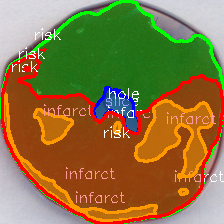

In [ ]:
image = segment_sample('sample.png')
cv2_imshow(image)

# Training script

Added augmentation to Dataset loader - getitem method

In [ ]:
class _Dataset(torch.utils.data.Dataset):
      
  def __init__(self, imgs, masks):
      self.imgs = imgs
      self.masks = masks

  def __len__(self):
      return self.imgs.shape[0]
      
  def __getitem__(self, idx):
      image = self.imgs[idx]
      mask = self.masks[idx]
      
      image = TF.to_tensor(image)
      mask = TF.to_tensor(mask)
      
      if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

      if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        
      if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

      return (image, mask)

class _Dataset_test(torch.utils.data.Dataset):

  def __init__(self, imgs, masks):
      self.imgs = imgs
      self.masks = masks

  def __len__(self):
      return self.imgs.shape[0]
  
  def __getitem__(self, idx):
      image = self.imgs[idx]
      mask = self.masks[idx]
      
      image = TF.to_tensor(image)
      mask = TF.to_tensor(mask)

      return (image, mask)

def train(Net, DataLoader, optimizer,  criterion, device, AvgLoss):
    Net.train()
    IterNum = 0.0 
    for batch_idx, (data_x, data_y) in enumerate(DataLoader):
        datax, datay = data_x.to(device), data_y.to(device)
        if batch_idx % 20 == 0:
          print(" No. of batch: " + str(batch_idx))
        datax = datax/127.5-1.0
        optimizer.zero_grad()
        response = Net(datax)
        
        loss = criterion(response, datay.float())
        
        loss.backward()

        print("  Batch loss: " + str(round(loss.item(),3)))
        AvgLoss += float(loss.item())
        IterNum += 1.0
        optimizer.step()
    AvgLoss = AvgLoss/IterNum
    return AvgLoss

def test(Net, test_loader,  criterion ,device):
    Net.eval()
    print(" Testing...")
    AvgLoss = 0.0
    IterNum = 0.0
    with torch.no_grad(): 
      for batch_idx, (data_x, data_y) in enumerate(test_loader):
        datax, datay = data_x.to(device), data_y.to(device)
        datax = datax/127.5-1.0
        response = Net(datax)
        
        loss = criterion(response, datay.float())
        if batch_idx % 10 == 0:
          print("  Test Batch: ", batch_idx)
        AvgLoss += float(loss.item())
        IterNum += 1.0
    AvgLoss = AvgLoss/IterNum
    return AvgLoss



In [ ]:
curr_dir = os.path.abspath(os.getcwd())

def train_for_epochs(Net, train_loader, test_loader, criterion, save_name, epoch_numb, best_loss):
  Net.train()
  backup_savename = save_name[:-3] + "_last.pt"
  backup_epoch = 0
  for dropout, learning_rt in combinations:
    print("learning rate -> ", learning_rt)
    print("Is dropout? ->", dropout)
    optimizer = optim.Adam(Net.parameters(), lr = learning_rt)
    best_weights = copy.deepcopy(Net.state_dict())
    current_best_epoch = 0
    for epoch in range(epoch_numb):
      AvgLoss = 0.0
      print("Epoch: "+str(epoch))
      AvgLoss = train( Net, train_loader, optimizer, criterion, dev, AvgLoss)
      TestLoss = test( Net, test_loader, criterion, dev)
      print(" Avg Loss: " + str(AvgLoss)) 
      print(" Test Loss: " + str(TestLoss)) 
      if epoch == 0 and best_loss == 0:
        best_loss = TestLoss
      else:
        if TestLoss < best_loss:
          best_loss = TestLoss
          current_best_epoch = epoch
          backup_epoch = epoch
          print("Better parameters found...")
          best_weights = copy.deepcopy(Net.state_dict())  
          torch.save(Net.state_dict(), os.path.join(curr_dir,save_name))
          print("Parameters saved after epoch " + str(epoch) + ".")
      if epoch-19 > backup_epoch:
        torch.save(Net.state_dict(), os.path.join(curr_dir,backup_savename))
        backup_epoch = epoch
      if epoch == epoch_numb - 1:
        torch.save(Net.state_dict(), os.path.join(curr_dir,backup_savename))
  print("Best epoch was: " + str(current_best_epoch) + ".")
  Net.load_state_dict(best_weights)
  return Net

train_set  = np.float32((np.load('train_set_normalized_masks.npy')))
train_imgs = train_set[:, :, :, 0:3]
train_masks = train_set[:, :, :, 3:]
test_set  = np.float32((np.load('test_set_normalized_masks.npy')))
test_imgs = test_set[:, :, :, 0:3]
test_masks = test_set[:, :, :, 3:]

In [ ]:
n_classes = 4
n_epochs = 10
#learning_rate = 0.006
learning_rate = [0.001, 0.005, 0.006, 0.007, 0.01, 0.1]
dropout_options = [True, False]
combinations = list(itertools.product(dropout_options, learning_rate))
n_batch = 8
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = _Dataset(train_imgs, train_masks)
test_set = _Dataset_test(test_imgs, test_masks)
train_loader  = torch.utils.data.DataLoader(dataset = train_set, batch_size = n_batch, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = n_batch, shuffle = True)   

In [ ]:
Net1 = UNet2(3, n_classes).to(dev)
Net1  = train_for_epochs(Net1, train_loader, test_loader, nn.BCEWithLogitsLoss(), "ownUNet_1000_8_trf.pt", n_epochs, 0.0)

learning rate ->  0.001
Is dropout? -> True
Epoch: 0
 No. of batch: 0
  Batch loss: 0.693
  Batch loss: 0.565
  Batch loss: 0.498
  Batch loss: 0.459
  Batch loss: 0.461
  Batch loss: 0.417
  Batch loss: 0.442
  Batch loss: 0.459
  Batch loss: 0.4
  Batch loss: 0.384
  Batch loss: 0.37
  Batch loss: 0.387
  Batch loss: 0.366
  Batch loss: 0.358
  Batch loss: 0.345
  Batch loss: 0.357
  Batch loss: 0.349
  Batch loss: 0.336
  Batch loss: 0.299


KeyboardInterrupt: ignored

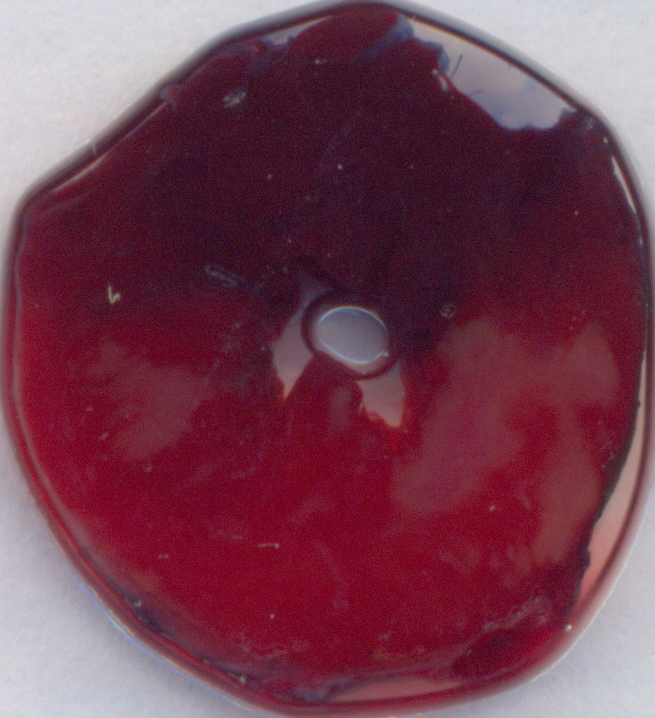

In [9]:
from PIL import Image


image_path = "/content/sample.png" 
image = Image.open(image_path)

image.show()


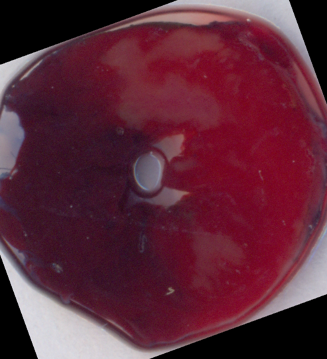

In [14]:
image_rotated = TF.rotate(image, 110)

width, height = image_rotated.size
new_width = width // 2  
new_height = height // 2 
resized_image = image_rotated.resize((new_width, new_height))



resized_image.show()


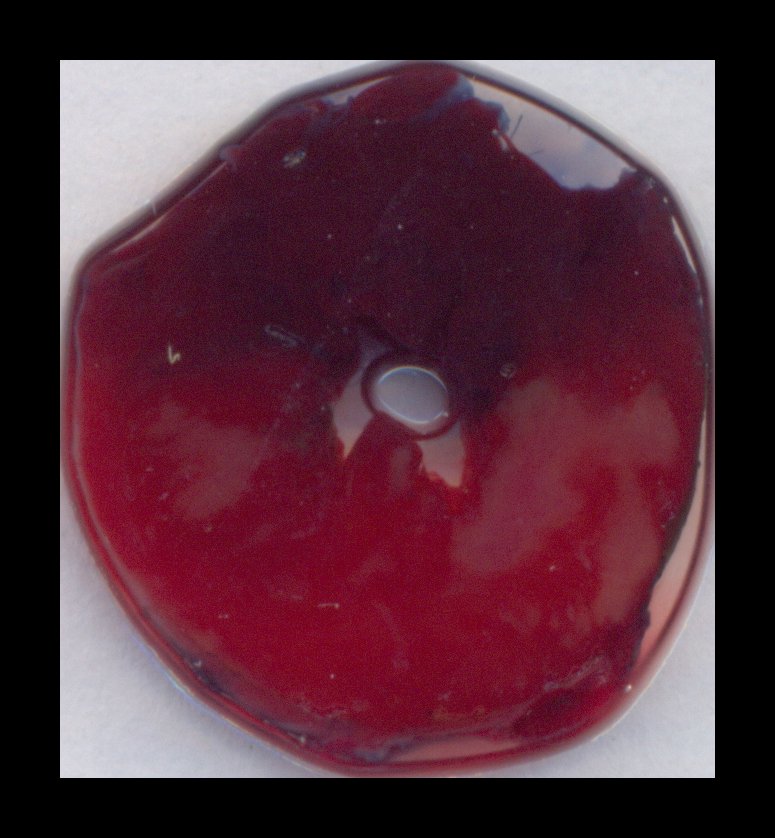

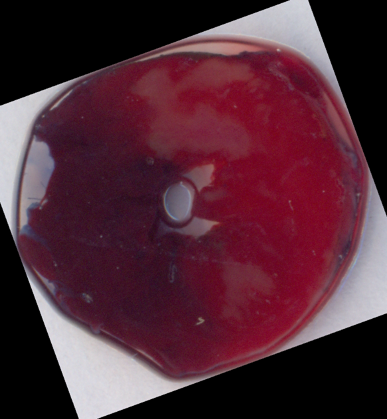

In [18]:
from PIL import Image, ImageOps

image_path = "/content/sample.png"
image = Image.open(image_path)


border_size = 60

# Add a white frame to the image
framed_image = ImageOps.expand(image, border=border_size, fill='black')

# Display the framed image
framed_image.show()

image_rotated = TF.rotate(framed_image, 110)

width, height = image_rotated.size
new_width = width // 2  
new_height = height // 2 
resized_image = image_rotated.resize((new_width, new_height))



resized_image.show()


We've added Dropuot, different Learning rates and augmentation. At the augmentation phase we have checked if rotation would cut off some parts. Unfortunately it does, but giving the samples a border would imporve, however we didnt have time to optimize its colour and its size for example.   